# 1. Import Dependencies

In [96]:
import pandas as pd
import numpy as np
import tensorflow as tf

import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers, initializers, regularizers, constraints, layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Activation 
from tensorflow.keras.layers import concatenate, AveragePooling2D, ZeroPadding2D, add, Reshape
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
from sklearn import metrics, manifold
from sklearn.metrics import matthews_corrcoef  
from sklearn.model_selection import train_test_split
from Data_loading import read_mg, read_us
from Attention_layers import Self_Attention
from sklearn.metrics import precision_score, recall_score, roc_auc_score
import tensorflow as tf
from tensorflow.keras.metrics import AUC
import matplotlib.pyplot as plt
import json


# 2. Load Config

In [97]:
# Load configuration from config.json
with open('config.json', 'r') as config_file:
    config = json.load(config_file)

# Set seed
tf.random.set_seed(config["seed"])

# Load configuration values
as_gray = config["as_gray"]
in_channel = config["in_channel"]
img_rows, img_cols = config["img_rows"], config["img_cols"]
num_classes = config["num_classes"]
batch_size = config["batch_size"]
all_epochs = config["all_epochs"]
input_shape = tuple(config["input_shape"])



# Define input shape
input_img = Input(shape=input_shape)


# 3. Load Train Data

In [98]:
import pandas as pd

# Load data
train_df = pd.read_excel(config["train_labels_path"])

# Print column names
print("Column names in train_df:", train_df.columns)

# Access the required columns if they exist
if 'CC_file' in train_df.columns and 'MLO_file' in train_df.columns:
    x_data = train_df[['CC_file', 'MLO_file']]
    print("Features (x_data):")
    print(x_data.head())
else:
    print("Columns 'CC_file' and 'MLO_file' not found in train_df.")


Column names in train_df: Index(['patient_id', 'CC_file', 'MLO_file', 'US_file', 'subtype', 'target'], dtype='object')
Features (x_data):
                                             CC_file  \
0  /Users/ellaquan/Project/Multimodal_data/train/...   
1  /Users/ellaquan/Project/Multimodal_data/train/...   
2  /Users/ellaquan/Project/Multimodal_data/train/...   
3  /Users/ellaquan/Project/Multimodal_data/train/...   
4  /Users/ellaquan/Project/Multimodal_data/train/...   

                                            MLO_file  
0  /Users/ellaquan/Project/Multimodal_data/train/...  
1  /Users/ellaquan/Project/Multimodal_data/train/...  
2  /Users/ellaquan/Project/Multimodal_data/train/...  
3  /Users/ellaquan/Project/Multimodal_data/train/...  
4  /Users/ellaquan/Project/Multimodal_data/train/...  


# 4. Extract features (image paths) and labels (target)

In [100]:
# Extract features (image paths) and labels (subtypes) by column name
x_data = train_df[['CC_file', 'MLO_file']]
y_data = train_df[['target']]  # Make sure there is a 'subtype' column

print("Features (x_data):")
print(x_data.head())
print("\nLabels (y_data):")
print(y_data.head())

Features (x_data):
                                             CC_file  \
0  /Users/ellaquan/Project/Multimodal_data/train/...   
1  /Users/ellaquan/Project/Multimodal_data/train/...   
2  /Users/ellaquan/Project/Multimodal_data/train/...   
3  /Users/ellaquan/Project/Multimodal_data/train/...   
4  /Users/ellaquan/Project/Multimodal_data/train/...   

                                            MLO_file  
0  /Users/ellaquan/Project/Multimodal_data/train/...  
1  /Users/ellaquan/Project/Multimodal_data/train/...  
2  /Users/ellaquan/Project/Multimodal_data/train/...  
3  /Users/ellaquan/Project/Multimodal_data/train/...  
4  /Users/ellaquan/Project/Multimodal_data/train/...  

Labels (y_data):
   target
0       1
1       0
2       0
3       0
4       0


In [102]:
from skimage.io import imread
from skimage.transform import resize
from skimage.color import gray2rgb
import numpy as np

def read_mg(file_paths, img_rows, img_cols, as_gray, channels):
    images = []
    for file_path in file_paths:
        # Load the image
        image = imread(file_path, as_gray=as_gray)
        
        # If grayscale and expecting RGB, convert to 3 channels
        if as_gray and channels == 3:
            image = gray2rgb(image)  # Converts to (height, width, 3)
        
        # Resize the image to the specified dimensions
        image = resize(image, (img_rows, img_cols), anti_aliasing=True)
        
        images.append(image)
    
    # Convert to numpy array and normalize
    images = np.asarray(images, dtype=np.float32)
    images = (images - images.min()) / (images.max() - images.min())
    
    print(f"Shape before reshape: {images.shape}")  # Debugging print
    images = images.reshape(images.shape[0], img_rows, img_cols, channels)
    return images


# 5. Train Val Split

In [103]:
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.2, random_state=1203)

print("Uploading train_cc...")
x_train_CC = read_mg(x_train.CC_file.values, img_rows, img_cols, as_gray, in_channel)
print("Done!")
print("------------------------------------------------------------------------------------------------")
print("Uploading train_mlo...")
x_train_MLO = read_mg(x_train.MLO_file.values, img_rows, img_cols, as_gray, in_channel)
print("Done!")
print("------------------------------------------------------------------------------------------------")


Uploading train_cc...
Shape before reshape: (109, 256, 256, 3)
Done!
------------------------------------------------------------------------------------------------
Uploading train_mlo...
Shape before reshape: (109, 256, 256, 3)
Done!
------------------------------------------------------------------------------------------------


In [104]:
y_train = y_train.target.values
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)

In [105]:

print("Uploading val_cc...")
x_val_CC = read_mg(x_val.CC_file.values, img_rows, img_cols, as_gray, in_channel)
print("Done!")
print("------------------------------------------------------------------------------------------------")
print("Uploading val_mlo...")
x_val_MLO = read_mg(x_val.MLO_file.values, img_rows, img_cols, as_gray, in_channel)
print("Done!")
print("------------------------------------------------------------------------------------------------")
y_val = y_val.target.values
y_val = tensorflow.keras.utils.to_categorical(y_val, num_classes)
print("------------------------------------------------------------------------------------------------")


Uploading val_cc...
Shape before reshape: (28, 256, 256, 3)
Done!
------------------------------------------------------------------------------------------------
Uploading val_mlo...
Shape before reshape: (28, 256, 256, 3)
Done!
------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------


# 6. Model


In [107]:
base1=ResNet50(weights='imagenet',include_top=False,input_shape=(256, 256, 3))
base2=ResNet50(weights='imagenet',include_top=False,input_shape=(256, 256, 3))
for layer in base1.layers :
    layer._name = layer.name + str('_1')
for layer in base2.layers :
    layer._name = layer.name + str('_2')

In [108]:
MLO_model = Model(inputs=base1.input, outputs=base1.get_layer('conv4_block6_out_1').output)
CC_model = Model(inputs=base2.input, outputs=base2.get_layer('conv4_block6_out_2').output)

x_mlo=MLO_model.output
x_cc=CC_model.output


In [134]:
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC

# Combine the outputs from MLO and CC views
x = concatenate([x_mlo, x_cc])
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax', name='output')(x)

# Define the final model
model = Model(inputs=[MLO_model.input, CC_model.input], outputs=output)

# Compile the model with custom metrics
model.compile(
    optimizer=Adam(lr=0.001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),  # Specificity
        Recall(name='recall'),        # Sensitivity
        AUC(name='auc')
    ]
)

/Users/ellaquan/miniconda3/envs/d2l/lib/python3.9/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# 7. Train Model Loss, Accuracy, Precision, Recall, and AUC-ROC

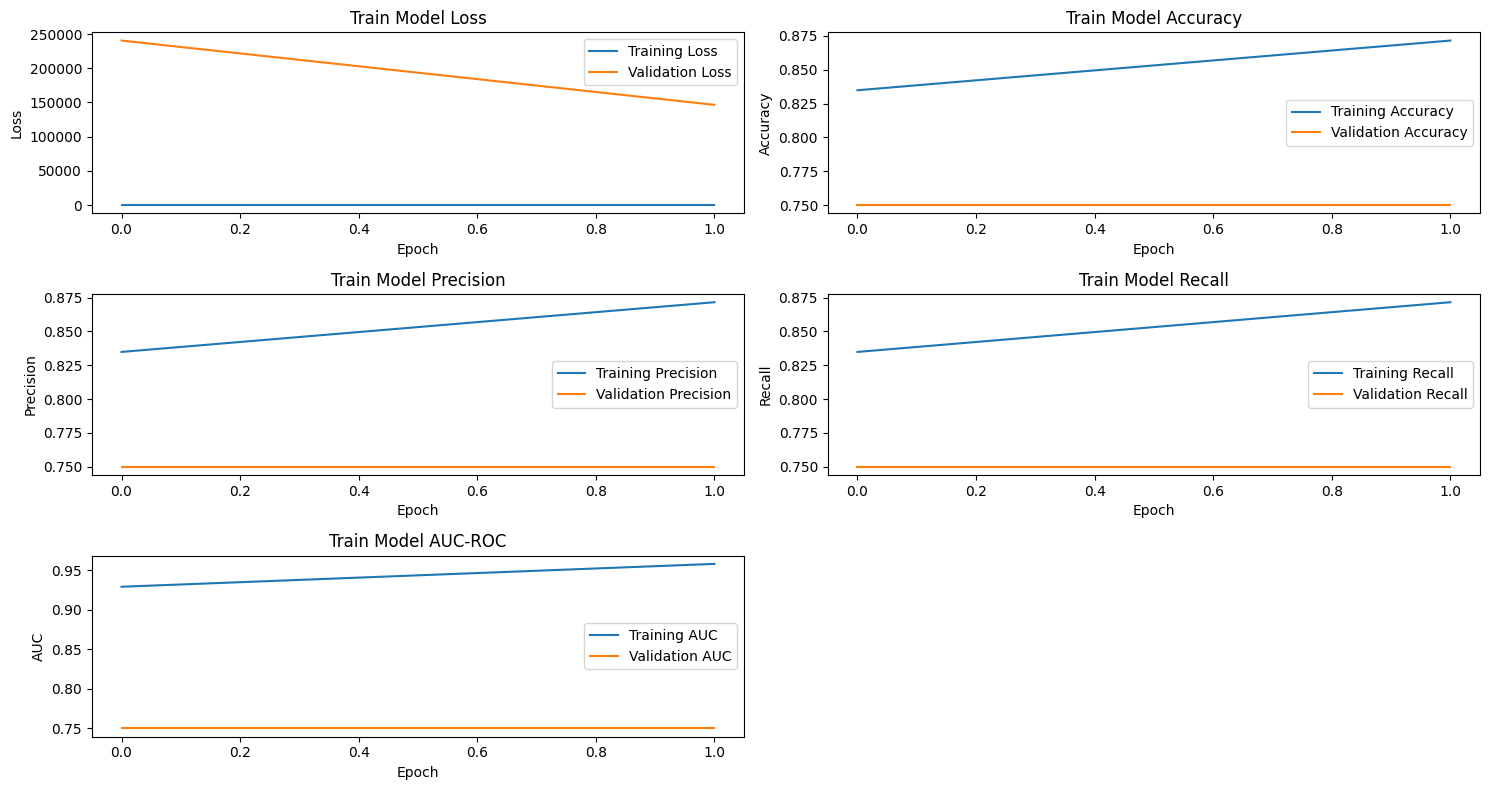

In [138]:
plt.figure(figsize=(15, 8))

# Loss
plt.subplot(3, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(3, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Train Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Precision
plt.subplot(3, 2, 3)
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Train Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(3, 2, 4)
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Train Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# AUC
plt.subplot(3, 2, 5)
plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('Train Model AUC-ROC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()


# 8. Simple bottleneck block - 1x1, 3x3, 1x1

In [110]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add

def bottleneck_Block(x, nb_filters, strides=(1, 1), with_conv_shortcut=False):
    # First component of the bottleneck block
    x_res = Conv2D(nb_filters[0], (1, 1), strides=strides)(x)
    x_res = BatchNormalization()(x_res)
    x_res = Activation('relu')(x_res)
    
    # Second component of the bottleneck block
    x_res = Conv2D(nb_filters[1], (3, 3), padding='same')(x_res)
    x_res = BatchNormalization()(x_res)
    x_res = Activation('relu')(x_res)
    
    # Third component of the bottleneck block
    x_res = Conv2D(nb_filters[2], (1, 1))(x_res)
    x_res = BatchNormalization()(x_res)

    # Shortcut connection
    if with_conv_shortcut:
        shortcut = Conv2D(nb_filters[2], (1, 1), strides=strides)(x)
        shortcut = BatchNormalization()(shortcut)
        x_res = Add()([x_res, shortcut])
    else:
        x_res = Add()([x_res, x])

    x_res = Activation('relu')(x_res)
    return x_res


In [111]:
def scheduler(epoch):
    if (epoch) % (10) == 0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr * 0.9)
        print("lr changed to {}".format(lr * 0.9))
    return K.get_value(model.optimizer.lr)

reduce_lr = LearningRateScheduler(scheduler)

# path to save the model
best_weights_file="Users/ellaquan/project/MG.weights.best.hdf5"

# checkpoint, callbacks 
checkpoint = ModelCheckpoint(best_weights_file, monitor='val_f1', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
callbacks = [checkpoint, reduce_lr]

# Training model
history=model.fit([x_train_MLO,x_train_CC],y_train,batch_size=batch_size, epochs=all_epochs, callbacks=callbacks, verbose=1, validation_data=([x_val_MLO,x_val_CC],y_val),shuffle=True)


lr changed to 0.0009000000427477062
Epoch 1/2
4/4 [==============================] - ETA: 0s - loss: 1.7444 - accuracy: 0.6972 - precision: 0.6972 - recall: 0.6972 - auc: 0.7748 WARNING:tensorflow:Can save best model only with val_f1 available, skipping.


4/4 [==============================] - 138s 31s/step - loss: 1.7444 - accuracy: 0.6972 - precision: 0.6972 - recall: 0.6972 - auc: 0.7748 - val_loss: 7929.3569 - val_accuracy: 0.7500 - val_precision: 0.7500 - val_recall: 0.7500 - val_auc: 0.7500 - lr: 9.0000e-04
Epoch 2/2
4/4 [==============================] - ETA: 0s - loss: 0.5794 - accuracy: 0.7064 - precision: 0.7064 - recall: 0.7064 - auc: 0.8075 WARNING:tensorflow:Can save best model only with val_f1 available, skipping.


4/4 [==============================] - 124s 27s/step - loss: 0.5794 - accuracy: 0.7064 - precision: 0.7064 - recall: 0.7064 - auc: 0.8075 - val_loss: 95662.0391 - val_accuracy: 0.7500 - val_precision: 0.7500 - val_recall: 0.7500 - val_auc: 0.7500 - lr: 9.0000e-04


# 9. Test model metrics



In [112]:
import tensorflow as tf

# Clear any previous session state
tf.keras.backend.clear_session()

# Evaluate on test data, passing both input arrays as a list
results = model.evaluate([x_test_MLO, x_test_CC], y_test, batch_size=batch_size)
print(f"Test Accuracy: {results[1]:.4f}")
print(f"Test Precision (Specificity): {results[2]:.4f}")
print(f"Test Recall (Sensitivity): {results[3]:.4f}")
print(f"Test AUC: {results[4]:.4f}")


3/3 [==============================] - 6s 2s/step - loss: 191380.0781 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.5000 - auc: 0.5000
Test Accuracy: 0.5000
Test Precision (Specificity): 0.5000
Test Recall (Sensitivity): 0.5000
Test AUC: 0.5000


# 10. Plot Training and Validation Loss Curve

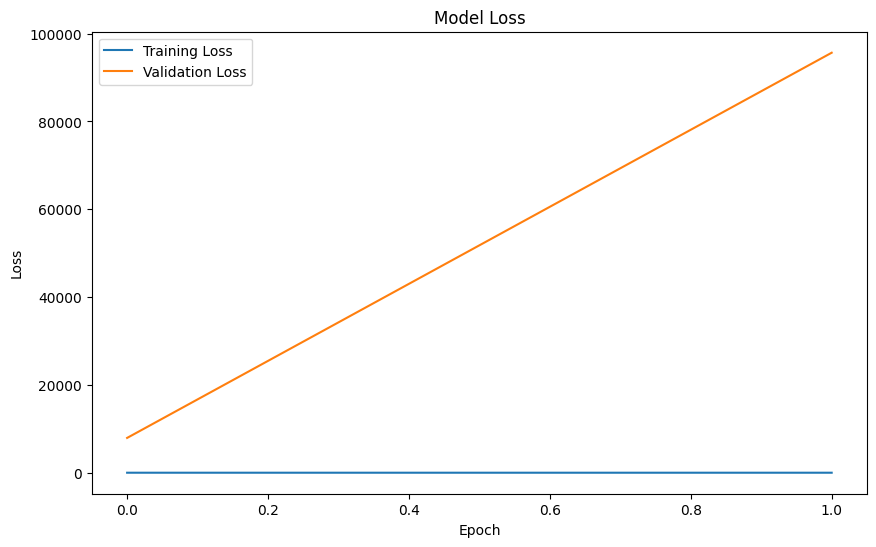

In [113]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('ResNet 50 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [119]:
# Load test data
test_df = pd.read_excel(config["test_labels_path"])

# Print column names for verification
print("Column names in test_df:", train_df.columns)

# Attempt to access the required columns if they exist
if 'CC_file' in test_df.columns and 'MLO_file' in test_df.columns:
    x_data = test_df[['CC_file', 'MLO_file']]
    print("Features (x_data):")
    print(x_data.head())
else:
    print("Columns 'CC_file' and 'MLO_file' not found in test_df.")


Column names in test_df: Index(['patient_id', 'CC_file', 'MLO_file', 'US_file', 'subtype', 'target'], dtype='object')
Features (x_data):
                                             CC_file  \
0  /Users/ellaquan/Project/Multimodal_data/test/0...   
1  /Users/ellaquan/Project/Multimodal_data/test/0...   
2  /Users/ellaquan/Project/Multimodal_data/test/0...   
3  /Users/ellaquan/Project/Multimodal_data/test/0...   
4  /Users/ellaquan/Project/Multimodal_data/test/0...   

                                            MLO_file  
0  /Users/ellaquan/Project/Multimodal_data/test/0...  
1  /Users/ellaquan/Project/Multimodal_data/test/0...  
2  /Users/ellaquan/Project/Multimodal_data/test/0...  
3  /Users/ellaquan/Project/Multimodal_data/test/0...  
4  /Users/ellaquan/Project/Multimodal_data/test/0...  


In [120]:
# Extract features (image paths) and labels (target) by column name
x_test = test_df[['CC_file', 'MLO_file']]
y_test = test_df[['target']]  # Make sure there is a 'target' column

print("Features (x_test):")
print(x_test.head())
print("\nLabels (y_test):")
print(y_test.head())


Features (x_test):
                                             CC_file  \
0  /Users/ellaquan/Project/Multimodal_data/test/0...   
1  /Users/ellaquan/Project/Multimodal_data/test/0...   
2  /Users/ellaquan/Project/Multimodal_data/test/0...   
3  /Users/ellaquan/Project/Multimodal_data/test/0...   
4  /Users/ellaquan/Project/Multimodal_data/test/0...   

                                            MLO_file  
0  /Users/ellaquan/Project/Multimodal_data/test/0...  
1  /Users/ellaquan/Project/Multimodal_data/test/0...  
2  /Users/ellaquan/Project/Multimodal_data/test/0...  
3  /Users/ellaquan/Project/Multimodal_data/test/0...  
4  /Users/ellaquan/Project/Multimodal_data/test/0...  

Labels (y_test):
   target
0       0
1       0
2       0
3       1
4       0


In [121]:
# Test model
x_test_CC = read_mg(x_test.CC_file.values, img_rows, img_cols, as_gray, in_channel)
print("Done!")
print("------------------------------------------------------------------------------------------------")
print("Uploading test_mlo...")
x_test_MLO = read_mg(x_test.MLO_file.values, img_rows, img_cols, as_gray, in_channel)
print("Done!")
print("------------------------------------------------------------------------------------------------")

Shape before reshape: (84, 256, 256, 3)
Done!
------------------------------------------------------------------------------------------------
Uploading test_mlo...
Shape before reshape: (84, 256, 256, 3)
Done!
------------------------------------------------------------------------------------------------


In [71]:
# Convert y_test to categorical format if required by model
y_test = tf.keras.utils.to_categorical(y_test.values, num_classes)

# Load model weights
model.load_weights(best_weights_file)

# Make predictions
predictions = model.predict([x_test_MLO, x_test_CC], batch_size=32)

# Convert y_test and predictions to class labels
y_test = y_test.argmax(axis=1)
y_pred = predictions.argmax(axis=1)

# Compute confusion matrix
matrix = metrics.confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(matrix)

# Calculate Matthews Correlation Coefficient (MCC)
MCC = matthews_corrcoef(y_test, y_pred)
print("Matthews Correlation Coefficient (MCC):", MCC)

3/3 [==============================] - 21s 7s/step
Confusion matrix:
[[70  0]
 [14  0]]
Matthews Correlation Coefficient (MCC): 0.0


# 11. Metrics Curves (Loss, Accuracy, Precision, Recall, AUC)

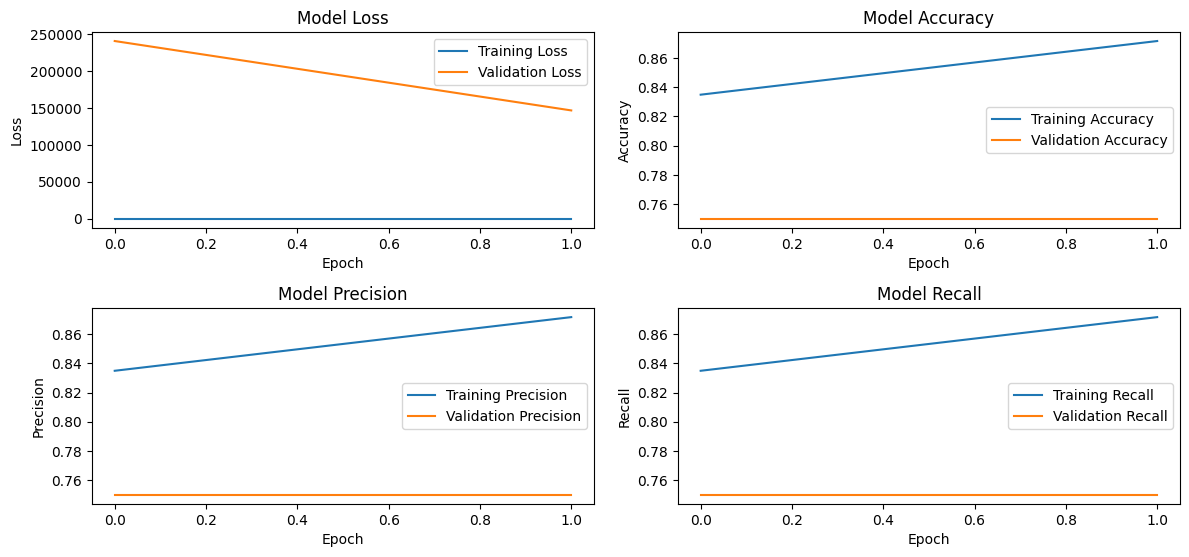

In [131]:
# Plot other metrics
plt.figure(figsize=(12, 8))

# Loss
plt.subplot(3, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(3, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Precision (Specificity)
plt.subplot(3, 2, 3)
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall (Sensitivity)
plt.subplot(3, 2, 4)
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


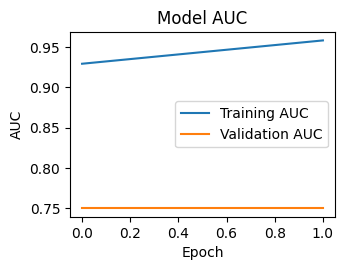

In [132]:
# AUC
plt.subplot(2, 2, 4)
plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

==END==